<img src="images/Logo_UCLL_ENG_RGB.png" style="background-color:white;" />

# Data & Artificial Intelligence

Lecturer: Jan D'Espallier

Academic year 2023-2024

## Neural Networks in action.

<center> Artificial Neural networks (ANN) </center>
<br>
<center><img src="images/neural network.webp" style="background-color:white; max-width:35%"></center>

The purpose of this notebook is that you set some first steps in training a Neural net. Training neural networks requires knowledge about data preparation, over-fitting, under-fitting, basic notions of stochastic gradient descent, validation, ... Hopefully you will get a better feeling about what that actually all means.

Note : These days, using existing/pre-designed/pre-trained neural networks is more easy and often more performing than training a model yourself using ```sci-kit learn```.    However some things can feel like magic if you are unclear about some of the fundamentals. That is okay, just like we covered in stochastic gradient descent, learning is an iterative process. We will attempt to give you the basics in the following sessions and from then it's up to you to try things out, make mistakes, find the answers by asking us/reading the documentation, correcting them and trying again.

caveat : It may very well be that not all of you will reach the end of this notebook by this workshop. No worries. You will get the fully completed notebook afterwards..such that can can play around with it @ home.

## How this notebook works..
In this notebook you'll find cells that start with a ❓. These cells contain a question or a task.
Insert an extra cell after these and either formulate an answer or fill in some code.
After the workshop you'll get the fully completed notebook, such that you can use it @home to see potential solutions.

## Getting your environment ready
This notebook has been test in an anaconda environment on windows with python 3.11.9 installed

It should run as well on Linux and or with other versions of python as long as the correct packages have been installed.
pip install -r requirements should do the job

☑ Installing the packages manually is also an option. 

- pip install jupyter
- pip install tensorflow
- pip install matplotlib
- pip install scikit-learn
- pip install seaborn

For the last part on hyperprarmeter tuning  
- pip install optuna
- pip install plotly

In [44]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns

## Introduction to Tensorflow

Tensorflow gets its name from  something from Mathematics. A tensor is simply a N-dimensional matrix. Color images are an example of a tensor, each pixel has R, G and B values. Alternatives to Tensorflow are Pytorch and MXnet.

<center><img src= "images/tensor.png" style="background-color:white; max-width:50%"></center>

```Keras``` is the high-level API of Tensorflow and what we recommend you use in this course. ```Keras``` contains two API's, the ```Sequential``` API and the ```Functional``` API. You're free to use whichever you prefer the most. The ```Sequential``` API tends to be a bit easier, but with slightly less flexibility. Finally there is also model subclassing.

## The data
We will start this on a very simple dataset called the MNIST handwritten digit classification dataset.
Fortunately, keras exposes some functions to easily load this dataset for experiments.
The function splits the data immediately into a training and a test set. ( it always uses a 60/10 split )

In [45]:
mnist = tf.keras.datasets.mnist # We load our data
(x_train, y_train),(x_test, y_test) = mnist.load_data() 

In [46]:
x_train[0].shape

(28, 28)

The images only have 1 channel, so they are in gray-scale.

Let's look at some examples to get a feeling about our data.

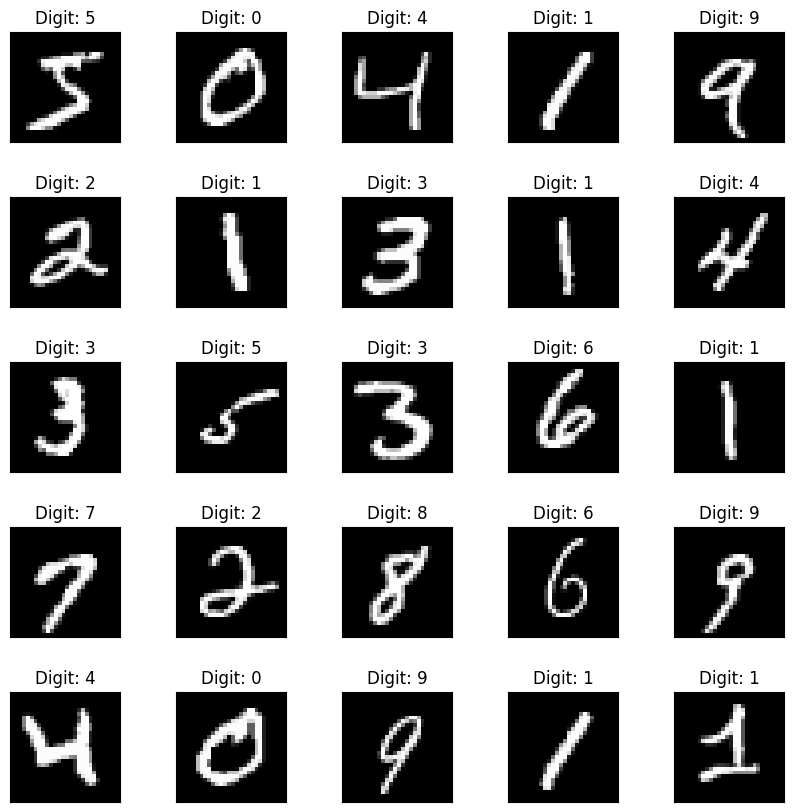

In [47]:
# Create a 5x5 grid of subplots
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))

# Adjust the spacing
fig.subplots_adjust(hspace=0.5, wspace=0.5)

# Plot the first 25 images
for i, ax in enumerate(axes.flat):
    # Display an image
    # ax.imshow(x_train[i])
    ax.imshow(x_train[i], cmap='gray')
    
    # Title with the corresponding digit
    ax.set_title(f"Digit: {y_train[i]}")
    
    # Remove x and y axis ticks
    ax.set_xticks([])
    ax.set_yticks([])

# Show the plot
plt.show()

In a real life scenario, it is advised to carefully look at **all** the data presented. In most case, you will be supplied with a lot of rubbish.
The first step in improving the performance of you r network is to clean everything carefully. Here...we are lucky to have a clean db already. :-)

Let's split the training set again in a training set and a validation set ( although you could have the keras fit function do that for you as well)

In [48]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

##### ☑ How many samples dow we have now for each set?

In [49]:
val_len = len(x_val)
train_len = len(x_train)
test_len = len(x_test)

print(f' Training set: {len(x_train)}, Validation Set: {len(x_val)}, Test Set: {len(x_test)}, Total: {val_len + train_len + test_len}')

 Training set: 48000, Validation Set: 12000, Test Set: 10000, Total: 70000


In [50]:
# Check the range of values in x_train
print ('max value in training set:'+str(np.amax(x_train)))

# Check the range of values in y_train
print ('max value in training set:'+str(np.amax(y_train)))

max value in training set:255
max value in training set:9


In [51]:
# neural nets perform best when input is normalised
x_train, x_test = x_train / 255.0, x_test / 255.0 # Scale the data to be between 0 and 1

##### ☑ Use plt.imshow to plot image. Does it still look the same?

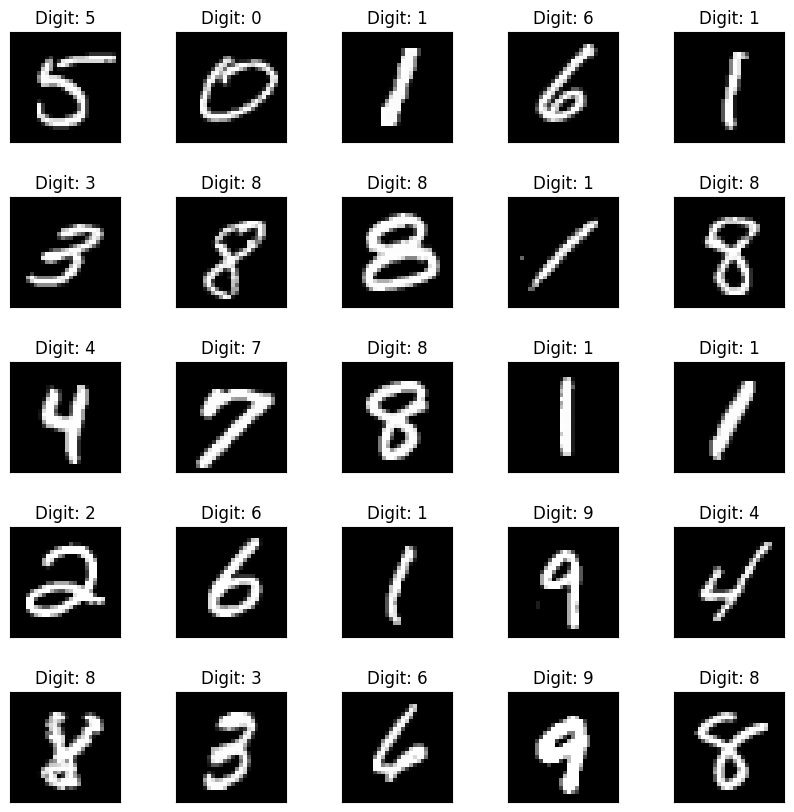

In [52]:
# Create a 5x5 grid of subplots
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))

# Adjust the spacing
fig.subplots_adjust(hspace=0.5, wspace=0.5)

# Plot the first 25 images
for i, ax in enumerate(axes.flat):
    # Display an image
    # ax.imshow(x_train[i])
    ax.imshow(x_train[i], cmap='gray')
    
    # Title with the corresponding digit
    ax.set_title(f"Digit: {y_train[i]}")
    
    # Remove x and y axis ticks
    ax.set_xticks([])
    ax.set_yticks([])

# Show the plot
plt.show()

In [53]:
# Check the range of values in x_train
print ('max value in training set:'+str(np.amax(x_train)))

# Check the range of values in y_train
print ('max value in training set:'+str(np.amax(y_train)))

max value in training set:1.0
max value in training set:9


When working with neural nets, lots of things happen at random. (e.g weight initialization). In order to make your results reproducible during development...you can/have to 'seed' the random generators. 

In [54]:
np.random.seed(42)
tf.random.set_seed(42)

## Sequential API

### Try 1: Sequential API first example

The sequential API is the most straightforward way to define models in Tensorflow Keras. The first class of importance is the ```Sequential``` class. This takes a list of ```Layers```. 

Considering our image comes in a grid of 28x28 we need to flatten it into a 1D vector. We can use ```Flatten``` for that.

The most important layer to understand is the ```Dense``` layer. A ```Dense``` layer is a layer where each neuron is connected to each input. Within a dense layer you need to specify how many neurons (each neuron is one linear regression) are and what activation function (see: advanced modeling part 1) you want to use. For classification we recommend that you have hidden layers with ```activation='relu```.

When designing a classifier, the final layer often has 'softmax' as activation.  This activation ensures that **all ouputs sum up to 1**. In this way will the outputs represent the 'probability' that an image belongs to a certain class.

This link contains a full list of possible layers Keras offers. https://keras.io/api/layers/ 

In [55]:
firstModel = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(28, 28)),  # Define the input shape explicitly here
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(units=128, activation='relu'),
  tf.keras.layers.Dense(units=128, activation='relu'),
  tf.keras.layers.Dense(units=10, activation='softmax')
])


In [56]:
#An alternative way to program this would be
#firstModel = tf.keras.models.Sequential()
#firstModel.add(keras.layers.Flatten(input_shape=[28, 28]))
#firstModel.add(keras.layers.Dense(128, activation="relu"))
#firstModel.add(keras.layers.Dense(128, activation="relu"))
#firstModel.add(keras.layers.Dense(10, activation="softmax"))

##### ☑ Describe how this neural network looks like. What is it doing? What do the numbers mean?
Use model.summary() to visualise the model architecture in a textual way..

If you would install graphviz and xxx you could generate an image from your model architecture using plotmodel(model,show_shapes=True, show_layer_names=True)

In [57]:
firstModel.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,282 (462.04 KB)

 Trainable params: 118,282 (462.04 KB)

 Non-trainable params: 0 (0.00 B)

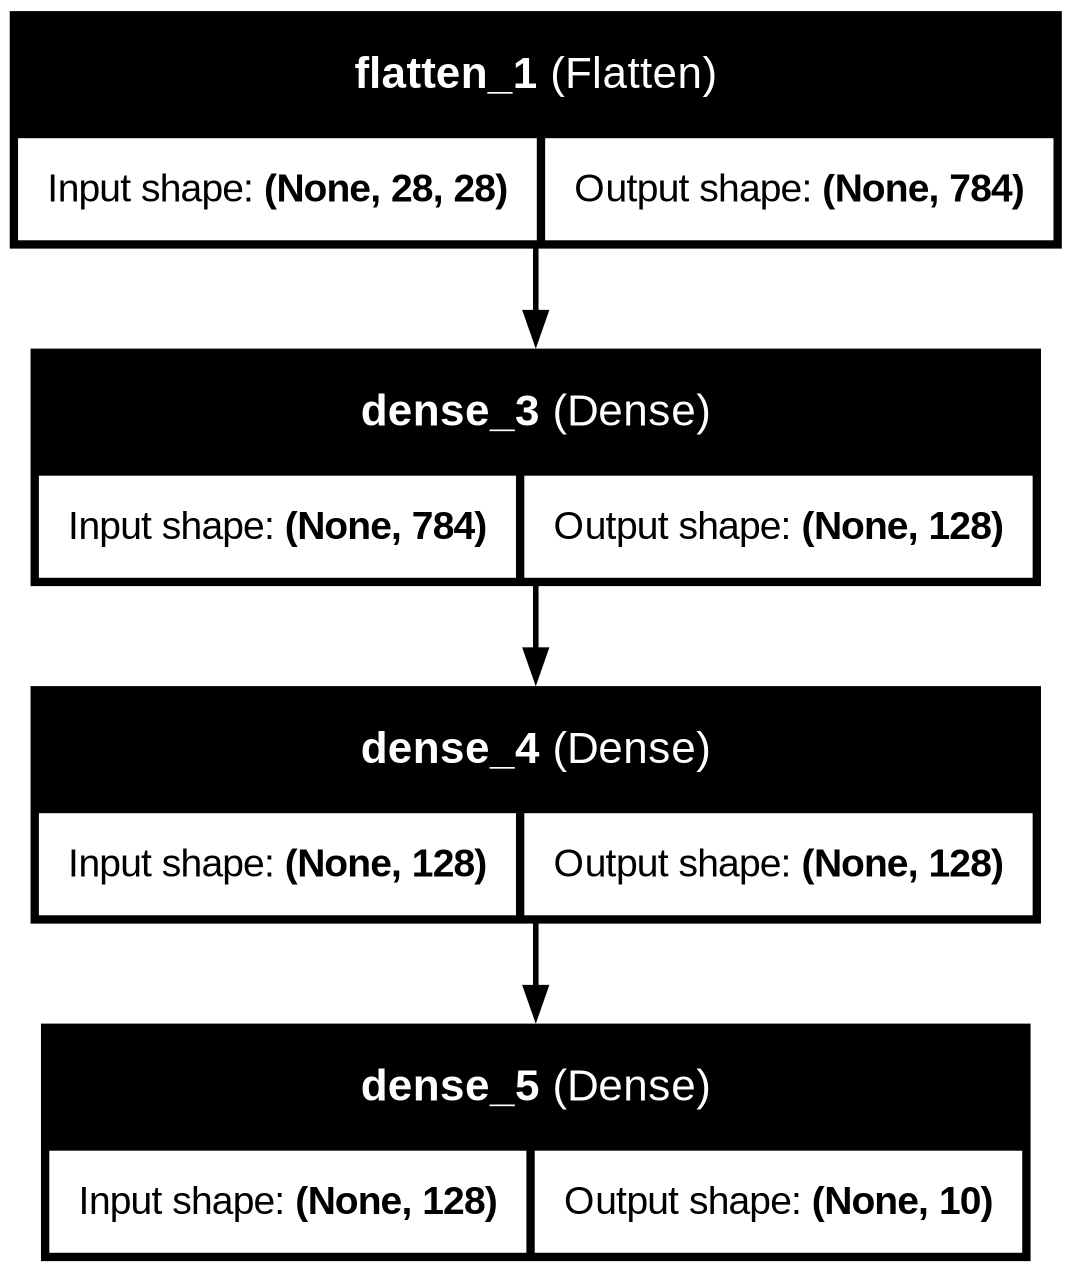

In [58]:

plot_model(firstModel,show_shapes=True, show_layer_names=True)

Our first layer flattens the input from 28x28 to 784. Afterwards this is passed to a Dense layer with 128 neurons, so 128 regressions. The output of each of these regressions is passed to a relu activation. If the output is negative it gets set to 0, if it's positive, it gets sent to the next layer.
In the final layer there are 10 neurons, 1 for each number. 
Softmax function converts output to probabilities

Before we can train our model we need to add an optimizer (remember: stochastic gradient descent), a loss function (the error the model uses to evaluate itself) and a metric (a human understandable metric).

We can add all of these by calling the compile method on the model.

💡 We recommend that you use Adam (variant of SGD) as an optimizer with a learning rate of specifically 3e-4, this is a convention / good starting point that is frequently used. For classification [categorical cross entropy](https://youtu.be/rkULCW_h09k) is used as a loss function.  You can tune this later if you want to. We use the 'sparse'variant as we present integers as labels...and not 'one hot encodings].

Full reference of losses: https://keras.io/api/losses/

Full reference of optimizers: https://keras.io/api/optimizers/



In [59]:
firstModel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

To train a model we can use ```.fit()``` as we know from ```sci-kit learn```.
There are a number of parameters we definitely need to supply to the .fit() method:

* ```batch_size```: The amount of training examples that are used to calculate the gradient.
    -  High(er) = more memory needed + more potential to over-fit, but faster training
    -  Low(er) = less memory needed + less potential to over-fit, but slower training.
    -  1 == SGD (stochastic gradient descent, after every sample ,the gradient is calculated and the weights are adapted.
* ```epochs```: The amount of iterations of gradient descent.

 ```Keras``` also provides handy features to make a validation set called ```validation_split```. If you set this parameter to 0.2, 20 % of the dataset is split off. After each epoch the performance is tested on this set. This can be used to check over-fitting **during** training. If the loss on validation is a lot higher than on training, you are over-fitting.

 💡 You can always interrupt a notebook cell that is training a network and use it in the subsequent cells. You will have the last best model.


Full reference of compile/fit: https://keras.io/api/models/model_training_apis/

Lets now train (aka fit) the model.

In [60]:
history = firstModel.fit(x_train[:1000], y_train[:1000], epochs=25, batch_size=10, validation_data=(x_val[:200], y_val[:200]))

Epoch 1/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5030 - loss: 1.7983 - val_accuracy: 0.7700 - val_loss: 28.5810
Epoch 2/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8360 - loss: 0.7934 - val_accuracy: 0.8450 - val_loss: 31.3416
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8940 - loss: 0.4617 - val_accuracy: 0.8900 - val_loss: 30.3402
Epoch 4/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9240 - loss: 0.3280 - val_accuracy: 0.8950 - val_loss: 31.5639
Epoch 5/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9430 - loss: 0.2484 - val_accuracy: 0.8950 - val_loss: 33.7452
Epoch 6/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9610 - loss: 0.1932 - val_accuracy: 0.8950 - val_loss: 36.5747
Epoch 7/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9760 - loss: 0.1518 - val_accuracy: 0.9000 - val_loss: 40.0108
Epoch 8/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9830 - loss: 0.1193 - val_accu

```Keras``` also provides handy features to make a validation set called ```validation_split```. If you set this parameter to 0.2, 20 % of the dataset is split off.

In [61]:
# alternative is to let keras split the dataset into a training and a validation set
# history = firstModel.fit(x_train[:1000], y_train[:1000], epochs=25, batch_size = 10, validation_split=0.2)
# we used the method above to have better control on which data is used for training and validation...

It is very important to look at what happened during the training. 
As we will have to do this often in this notebook, let's create a function to visualise the training history.

In [62]:
def plotTrainingHistory(history):
    # Create a figure and a set of subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))  # Adjusted figsize to better fit two subplots
    
    # Plot training and validation loss on the first subplot
    ax1.plot(history.history['loss'], label='train')
    ax1.plot(history.history['val_loss'], label='val')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    # Plot training and validation accuracy on the second subplot
    ax2.plot(history.history['accuracy'], label='train')
    ax2.plot(history.history['val_accuracy'], label='val')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    # Improve layout to prevent overlap
    plt.tight_layout()
    
    # Display the plot
    plt.show()

##### ☑  Use this function to plot the history. 

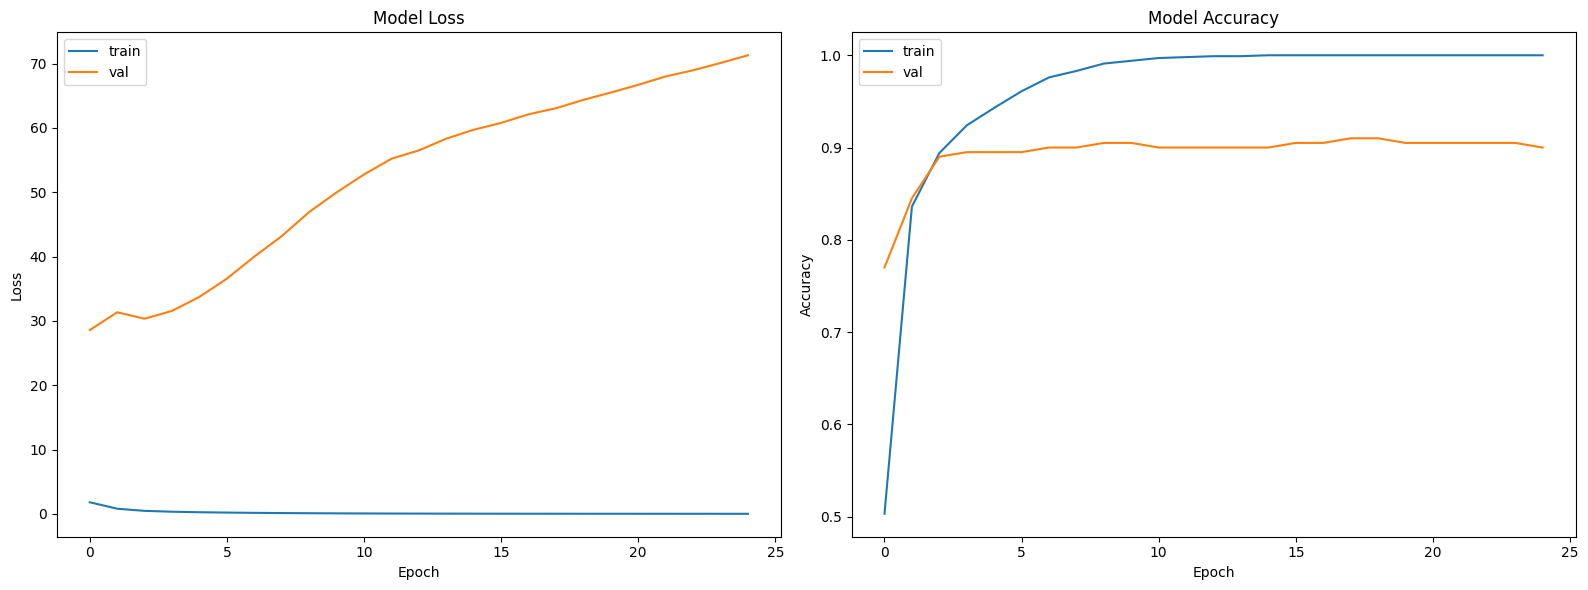

In [63]:
plotTrainingHistory(history)

##### ☑  How does the trend look like for validation and training?

after the 3rd epoch the loss increases and accuracy improvement drastically slows. The model gets overfitted fastly

First we want to make some prediction with the model. For once (and then never again (why not?)) we use the training samples to evaluate our performance.

In [64]:
y_train_pred=np.argmax(firstModel.predict(x_train[:1000]),axis=1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


As we will want to calculate model performance (accuracy and f1) multiple times in this notebook, we also make a function to do this for us.

In [65]:
def displayPerformanceFigures(real,pred,title,includeCF=True):
   if includeCF:
       # Compute confusion matrix
       cm = confusion_matrix(real, pred)
       sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
       plt.xlabel('Predicted labels')
       plt.ylabel('True labels')
       plt.title('Confusion Matrix for '+title+' samples')
       plt.show() 

   acc= accuracy_score(real, pred)
   print("Accuracy: ", acc)
    
   f1 = f1_score(real, pred, average='macro')
   print("F1 Score: ", f1)

##### ☑ How well is the model performing? Run the function we just made. (includeCF=True)
For ones you can use the first 1000 samples of the training data....but never do this again afterwards!

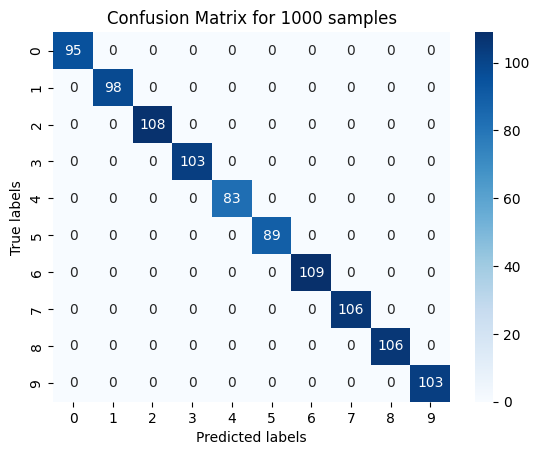

Accuracy:  1.0
F1 Score:  1.0


In [66]:
displayPerformanceFigures(y_train[:1000], y_train_pred, "1000")

...

##### ☑ Do the same evaluation as above but now on the 200 first validation samples. (includeCF=True)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


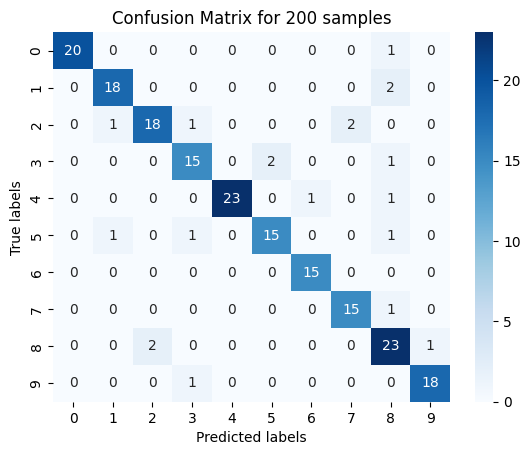

Accuracy:  0.9
F1 Score:  0.9027191974105925


In [69]:
y_val_pred=np.argmax(firstModel.predict(x_val[:200]),axis=1)
displayPerformanceFigures(y_val[:200], y_val_pred, "200")

Option: You could also use use model.evaluate() to check the performance on the test set. 
This method will make a prediction and an accuracy evaluation in 1 shot. An example below on the test set.

In [71]:
firstModel.metrics_names
firstModel.evaluate(x_test, y_test)

 41/313 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9022 - loss: 0.3471

2025-10-12 19:42:18.279199: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 31360000 exceeds 10% of free system memory.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9051 - loss: 0.3948


[0.39483076333999634, 0.9050999879837036]

In [72]:
firstModel.metrics_names
firstModel.evaluate(x_val, y_val)

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9000 - loss: 85.2088


[85.20882415771484, 0.8999999761581421]

##### How can we improve the performance and reduce the overfitting?

### Try 2 : More data

Same model architecture, but use more data to train :-). Redefine (and recompile) the model..to ensure weight re-initialisation.(otherwise we would start with a trained model..which would give an unfair comparison.

In [73]:
firstModel = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(28, 28)),  # Define the input shape explicitly here
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(units=128, activation='relu'),
  tf.keras.layers.Dense(units=128, activation='relu'),
  tf.keras.layers.Dense(units=10, activation='softmax')
])

firstModel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

In [74]:
history = firstModel.fit(x_train, y_train, epochs=25, batch_size=10, validation_data=(x_val, y_val))

Epoch 1/25


2025-10-12 19:43:21.974092: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 150528000 exceeds 10% of free system memory.


4800/4800 ━━━━━━━━━━━━━━━━━━━━ 35s 7ms/step - accuracy: 0.9158 - loss: 0.2964 - val_accuracy: 0.9567 - val_loss: 19.8731
Epoch 2/25
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - accuracy: 0.9633 - loss: 0.1269 - val_accuracy: 0.9665 - val_loss: 15.6687
Epoch 3/25
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 33s 7ms/step - accuracy: 0.9749 - loss: 0.0853 - val_accuracy: 0.9682 - val_loss: 15.9314
Epoch 4/25
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 29s 6ms/step - accuracy: 0.9824 - loss: 0.0606 - val_accuracy: 0.9703 - val_loss: 16.5419
Epoch 5/25
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 29s 6ms/step - accuracy: 0.9876 - loss: 0.0440 - val_accuracy: 0.9717 - val_loss: 18.5392
Epoch 6/25
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 31s 6ms/step - accuracy: 0.9913 - loss: 0.0327 - val_accuracy: 0.9715 - val_loss: 20.6699
Epoch 7/25
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 36s 7ms/step - accuracy: 0.9935 - loss: 0.0246 - val_accuracy: 0.9722 - val_loss: 23.1712
Epoch 8/25
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - accuracy: 0.9941 - loss: 0.020

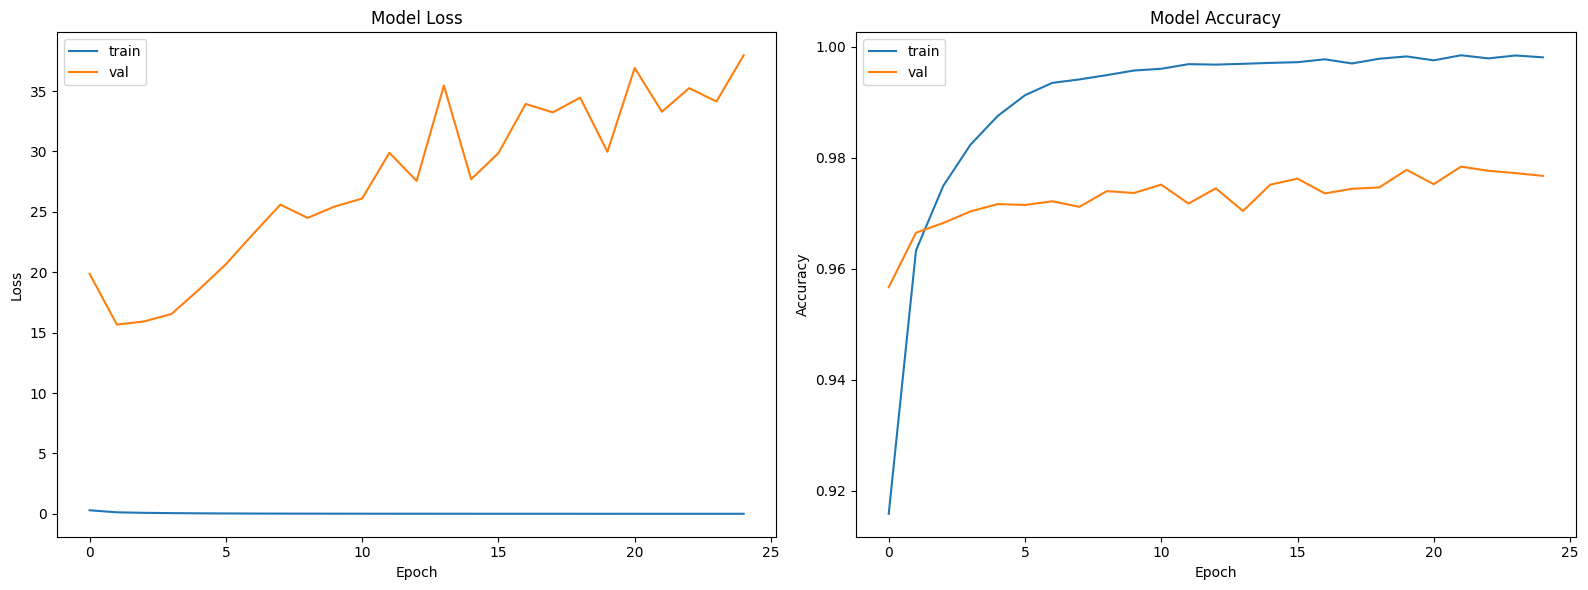

In [75]:
plotTrainingHistory(history)

##### ☑ Is the result better?

Yes, a bit better as the validation loss is lower, but the model still gets overfitted fast after even the 2nd epoch.

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


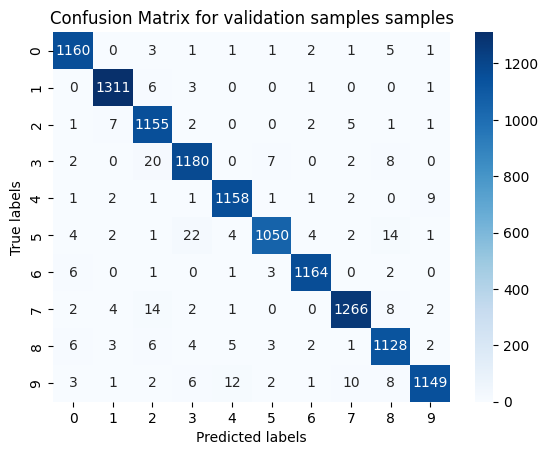

Accuracy:  0.97675
F1 Score:  0.976542899193203


In [76]:
y_val_pred=np.argmax(firstModel.predict(x_val),axis=1)
displayPerformanceFigures(y_val,y_val_pred,'validation samples',includeCF=True)

##### What if we do not have 'more data'? 

There are many tools available to apply **'data augmentation'**
Data augmentation can be done in different forms :
- slight rotation of the data
- horizontal image flipping (would that work here?)

The same label (y) can be used although the x value changes (rotated). So we end up having more data !

This augmentation can be applied in keras by inserting specific layers for this purpose.
  tf.keras.layers.RandomFlip("horizontal"),  # Randomly flips each image horizontally during training
  tf.keras.layers.RandomRotation(0.05),      # Randomly rotates each image during training

##### ☑ Will that work in this case ?  

we might try random rotations (less than 90 degrees), but flips are not applicable

Let's try it out (anyway) with the code below

Epoch 1/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.2300 - loss: 2.1663 - val_accuracy: 0.4800 - val_loss: 50.0665
Epoch 2/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4040 - loss: 1.8247 - val_accuracy: 0.6200 - val_loss: 65.2881
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4620 - loss: 1.5648 - val_accuracy: 0.6400 - val_loss: 70.6865
Epoch 4/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5280 - loss: 1.3807 - val_accuracy: 0.6600 - val_loss: 81.6215
Epoch 5/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5430 - loss: 1.3397 - val_accuracy: 0.6850 - val_loss: 94.4296
Epoch 6/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5750 - loss: 1.2556 - val_accuracy: 0.7300 - val_loss: 90.1396
Epoch 7/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5670 - loss: 1.2379 - val_accuracy: 0.7050 - val_loss: 93.5399
Epoch 8/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5780 - loss: 1.1822 - val_

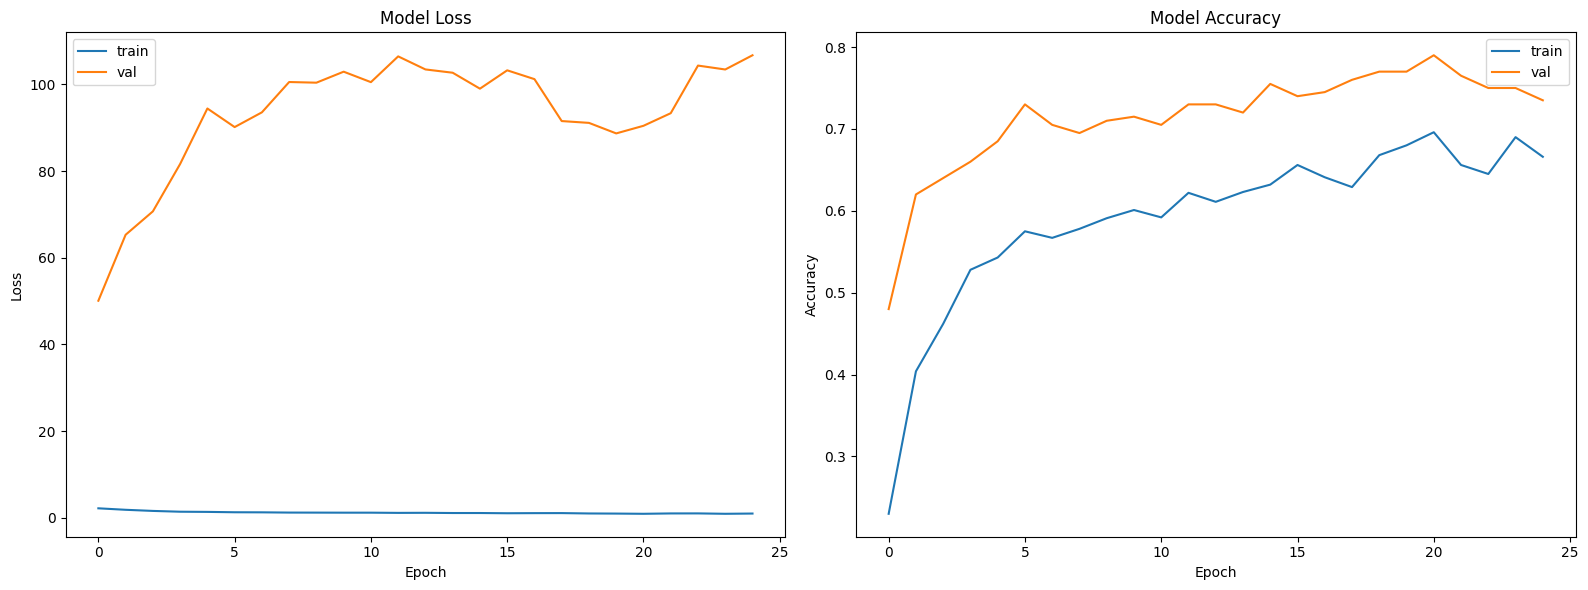

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


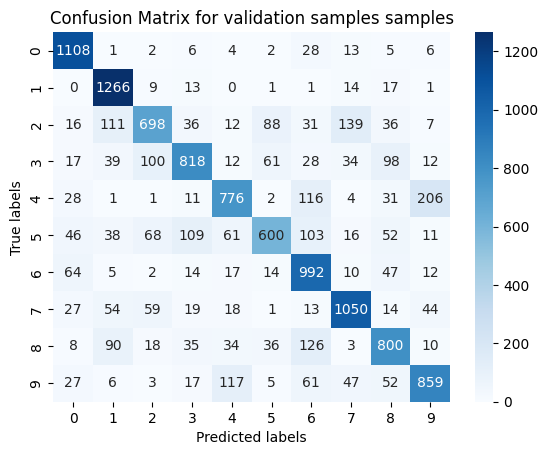

Accuracy:  0.74725
F1 Score:  0.7393886978343543


In [77]:
firstModelwithDA = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(28, 28)),  # Define the input shape explicitly here
  tf.keras.layers.RandomFlip("horizontal"),  # Randomly flips each image horizontally during training
  tf.keras.layers.RandomRotation(0.05),  # Randomly rotates each image during training
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(units=128, activation='relu'),
  tf.keras.layers.Dense(units=128, activation='relu'),
  tf.keras.layers.Dense(units=10, activation='softmax')
])
firstModelwithDA.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = firstModelwithDA.fit(x_train[:1000], y_train[:1000], epochs=25, batch_size=10, validation_data=(x_val[:200], y_val[:200]))
plotTrainingHistory(history)  
y_val_pred=np.argmax(firstModelwithDA.predict(x_val),axis=1)
displayPerformanceFigures(y_val,y_val_pred,'validation samples',includeCF=True)

##### ☑What do you see in the performance ?

Model does not get overfitted that fast anymore. Somehow validation set has more accuracy that train set. But the performance got worse (as we can see the accuracy now is about 0.75)

##### Is there another technique that you know, that can help you to assess potential performance of your model in case you have little amount of data?

Applying the K-Crossfold technique would give you K iterations to evaluate model performance potential. Voting over all models..will improve the performance. We will not elaborate on that technique here.
<center><img src= "images/crossfold.jpg" style="background-color:white; max-width:50%"></center>

##### How can we further reduce overfitting?

### Try 3 : reduce number of trainable parameters

We could make the model smaller by reducing the amount of neurons in the first layer.

💡 A common convention is to have the neurons be powers of 2 so 2, 4, 8, 16, 32, ...



In [78]:
np.random.seed(42)
tf.random.set_seed(42)

##### ☑ Make a model with 64 in the first and 32 neurons in the second Dense layer. For the rest the same as firstModel.

Epoch 1/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.2030 - loss: 2.1985 - val_accuracy: 0.4050 - val_loss: 46.5167
Epoch 2/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3770 - loss: 1.9260 - val_accuracy: 0.5950 - val_loss: 46.9371
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4660 - loss: 1.6916 - val_accuracy: 0.6500 - val_loss: 55.9678
Epoch 4/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5450 - loss: 1.4759 - val_accuracy: 0.6650 - val_loss: 58.6438
Epoch 5/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5840 - loss: 1.3339 - val_accuracy: 0.7050 - val_loss: 58.8900
Epoch 6/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6120 - loss: 1.2164 - val_accuracy: 0.7450 - val_loss: 62.3484
Epoch 7/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6590 - loss: 1.0942 - val_accuracy: 0.7500 - val_loss: 64.7313
Epoch 8/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6290 - loss: 1.1165 - val_accu

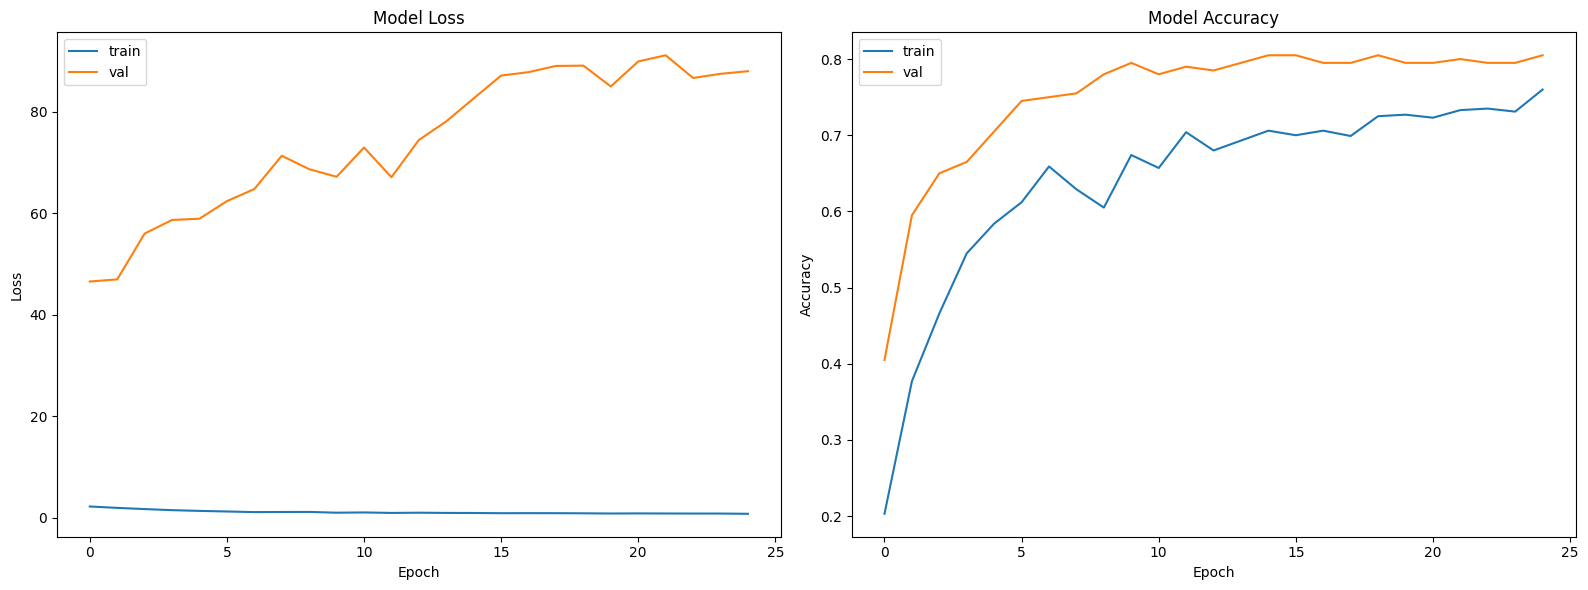

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


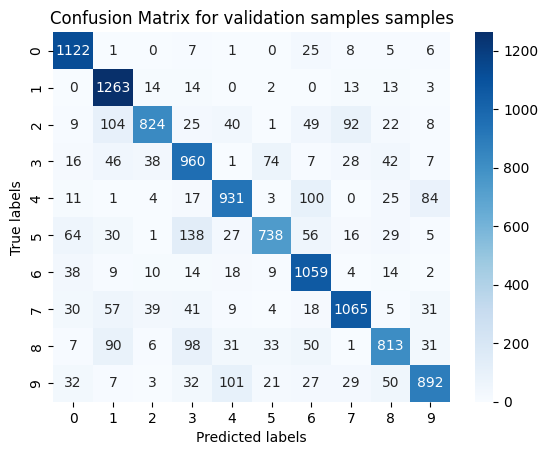

Accuracy:  0.8055833333333333
F1 Score:  0.8019582175127505


In [82]:
firstModelwithDA = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(28, 28)),  # Define the input shape explicitly here
  tf.keras.layers.RandomRotation(0.05),  # Randomly rotates each image during training
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(units=64, activation='relu'),
  tf.keras.layers.Dense(units=32, activation='relu'),
  tf.keras.layers.Dense(units=10, activation='softmax')
])
firstModelwithDA.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history = firstModelwithDA.fit(x_train[:1000], y_train[:1000], epochs=25, batch_size=10, validation_data=(x_val[:200], y_val[:200]))
plotTrainingHistory(history)  
y_val_pred=np.argmax(firstModelwithDA.predict(x_val),axis=1)
displayPerformanceFigures(y_val,y_val_pred,'validation samples',includeCF=True)

##### ☑ Compile , fit, plot history and evaluate performance as we did above. But now use the validation and/or the testset

 52/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

2025-10-12 20:10:58.777891: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 31360000 exceeds 10% of free system memory.


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


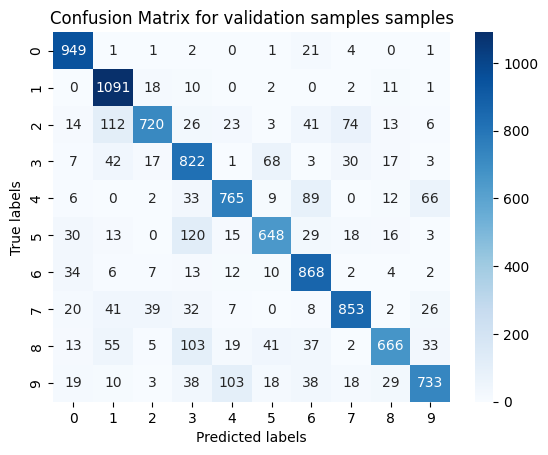

Accuracy:  0.8115
F1 Score:  0.8083924973022765


In [83]:
y_test_pred=np.argmax(firstModelwithDA.predict(x_test),axis=1)
displayPerformanceFigures(y_test,y_test_pred,'validation samples',includeCF=True)

##### ☑ How well is the model performing? How does the trend look like for validation and training? Do we need more epochs?

For me, the model performed a bit worse than previously. What improved it - removing horizontal flip. We may try more epochs as in after 20th epoch validation loss started decreasing while the accuracy kept gradually increasing. The train set does not show a better performance - so there is not overfitting.

The training loss actually starts higher than the validation loss but after some point you could say the model started over-fitting. The validation loss starts stagnating and even rises around epoch x. The loss is 1/3rd of what it used to be but the accuracy has dropped. It is very possible that your metric and your loss aren't completely aligned, you can improve in one while getting worse in the other.

#####  Based on how the plots look, how do you propose we solve this problem? How can we make a good model?

### Try 4 : Early stopping

We can do **early stopping**, we train a model and as soon as the validation loss rises for a set amount of iterations we stop the training and go back to the epoch that had the best loss.

<center><img src= "images/early stopping.png" style="background-color:white; max-width:50%"></center>

In [84]:
np.random.seed(42)
tf.random.set_seed(42)

In [85]:
# to ensure weigth re-initialisation , we first redefine the model
secondModel = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(28, 28)),  
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

Let's again compile and train this model ..then evaluate it's performance on the test data.
As we are lazy...(and good programmers are!) we define a function which we will use more often later on. This avoids some type work..and errors.

Notice the callback for early stopping!

In [86]:
def compile_and_train_model_then_evaluate_its_performance(mod):
    mod.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3) # If the validation loss rises for 3 epochs training is stopped
    history = mod.fit(x_train, y_train, epochs=25, batch_size=10, validation_data=(x_val, y_val), callbacks=callback)
    plotTrainingHistory(history)
    y_test_pred=np.argmax(mod.predict(x_test),axis=1)
    displayPerformanceFigures(y_test,y_test_pred,'test samples',includeCF=False)

##### ☑  Call this function on the second model

Epoch 1/25


2025-10-12 20:17:18.080119: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 150528000 exceeds 10% of free system memory.


4800/4800 ━━━━━━━━━━━━━━━━━━━━ 34s 6ms/step - accuracy: 0.8951 - loss: 0.3813 - val_accuracy: 0.9412 - val_loss: 25.5517
Epoch 2/25
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - accuracy: 0.9499 - loss: 0.1739 - val_accuracy: 0.9569 - val_loss: 20.0698
Epoch 3/25
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - accuracy: 0.9626 - loss: 0.1292 - val_accuracy: 0.9618 - val_loss: 17.7472
Epoch 4/25
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 34s 7ms/step - accuracy: 0.9703 - loss: 0.1037 - val_accuracy: 0.9635 - val_loss: 17.0675
Epoch 5/25
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - accuracy: 0.9754 - loss: 0.0860 - val_accuracy: 0.9654 - val_loss: 16.7972
Epoch 6/25
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - accuracy: 0.9789 - loss: 0.0726 - val_accuracy: 0.9676 - val_loss: 17.2253
Epoch 7/25
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 31s 7ms/step - accuracy: 0.9827 - loss: 0.0619 - val_accuracy: 0.9676 - val_loss: 17.4406
Epoch 8/25
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 33s 7ms/step - accuracy: 0.9859 - loss: 0.052

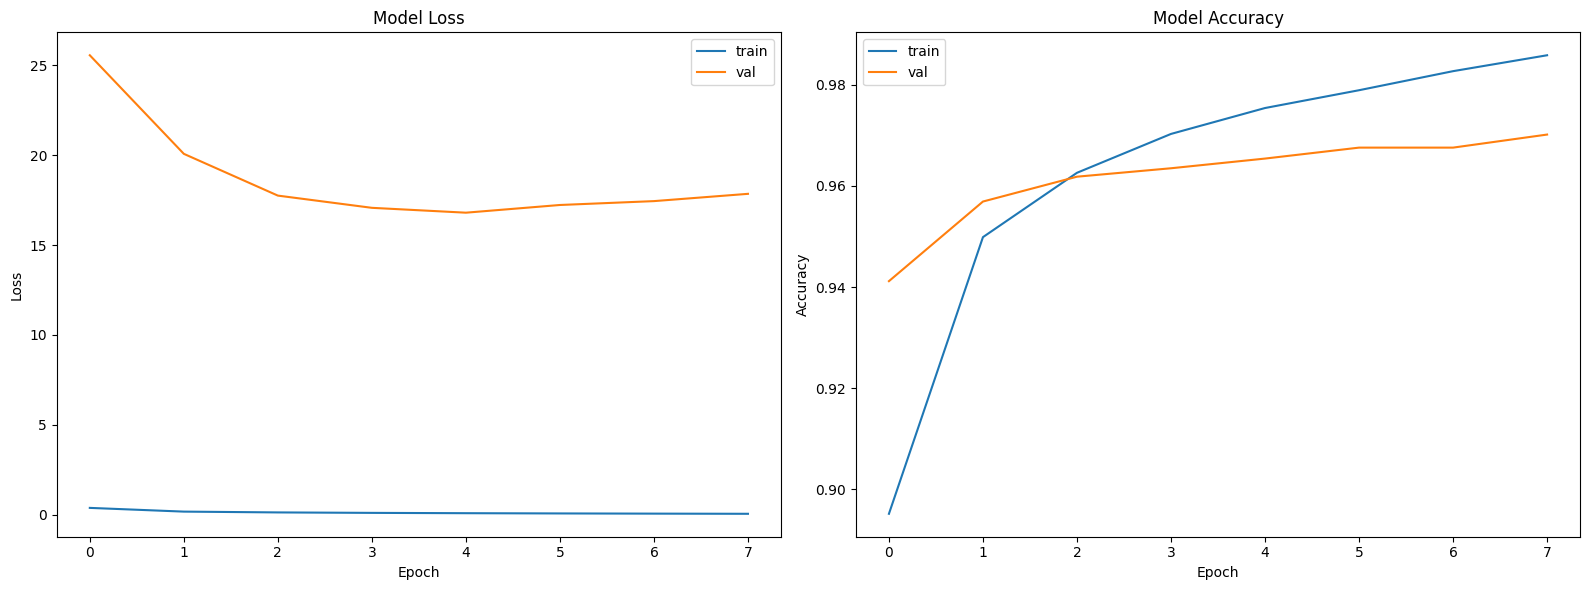

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Accuracy:  0.9691
F1 Score:  0.9689651268833097


In [87]:
compile_and_train_model_then_evaluate_its_performance(secondModel)

##### ☑  What is the danger of early stopping? 

It can be triggered by small fluctuations, which will not provide us the peak performance of the model.
If the validation set is noizy and small the patience should be higher and higher

### Try 5: Include regularisation 
There is another way (which you may have tried before) to tackle overfitting : regularisation.

Neural networks can also use regularization (confer the (C) parameter in support-vector machines.)

One way to regularise neural nets is ```Dropout``` layers. When training a neural network dropout randomly switches off a percentage of neurons in a layer. **It has been proven that this is a form of regularization.** It is the easiest one you can implement. You simply put a dropout layer between each dense layer.

<center><img src= "images/dropout.png" style="background-color:white; max-width:50%"></center>


In [88]:
tf.keras.layers.Dropout(0.2)

<Dropout name=dropout, built=True>

Drop out tends to reduce over-fitting, the training loss become significantly higher. By switching off neurons you're forced to learn a more general pattern. Dropout allows you to train larger networks while suffering less from over-fitting.

##### ☑ Create a bigger model..but with drop out regularisation
Increase the size of the first two layers of fifthModel to 128 and 128. (like in our first model)

Insert the drop out layer from above after the 1st and second dense layer.

Store in a variable called sixthModel.

Train and evaluate as previously. Comment on the Model's overfitting.

Epoch 1/25
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 43s 8ms/step - accuracy: 0.8858 - loss: 0.3829 - val_accuracy: 0.9529 - val_loss: 20.0859
Epoch 2/25
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 39s 8ms/step - accuracy: 0.9473 - loss: 0.1774 - val_accuracy: 0.9630 - val_loss: 16.0999
Epoch 3/25
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 36s 8ms/step - accuracy: 0.9609 - loss: 0.1318 - val_accuracy: 0.9681 - val_loss: 16.2235
Epoch 4/25
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 37s 8ms/step - accuracy: 0.9667 - loss: 0.1102 - val_accuracy: 0.9722 - val_loss: 14.5897
Epoch 5/25
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - accuracy: 0.9717 - loss: 0.0921 - val_accuracy: 0.9735 - val_loss: 15.2516
Epoch 6/25
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - accuracy: 0.9745 - loss: 0.0803 - val_accuracy: 0.9742 - val_loss: 15.7122
Epoch 7/25
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 47s 10ms/step - accuracy: 0.9772 - loss: 0.0729 - val_accuracy: 0.9753 - val_loss: 14.3312
Epoch 8/25
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 41s 8ms/step - accuracy: 0.9805 -

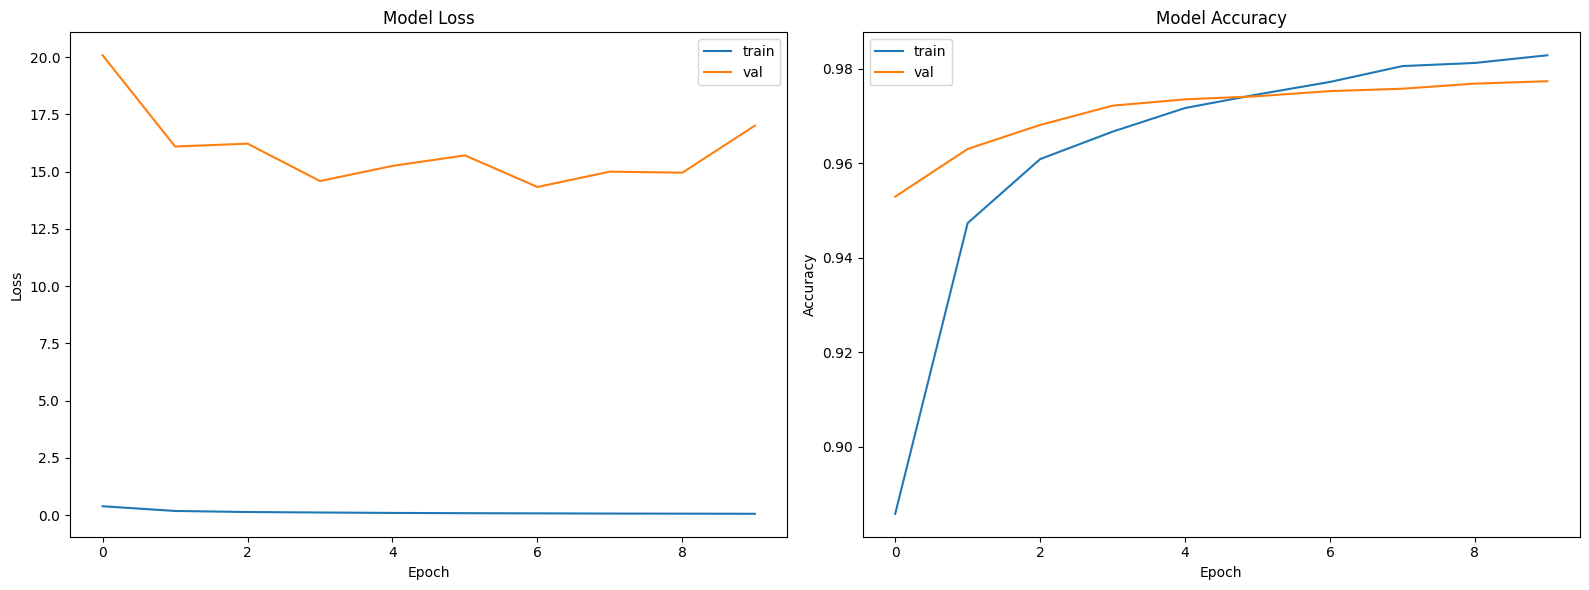

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy:  0.9785
F1 Score:  0.9783419834648373


In [91]:
sixthModel = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(28, 28)),  
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])
compile_and_train_model_then_evaluate_its_performance(sixthModel)

We have the best performance so far, but we can still see we are overfitting. We can improve by increasing the dropout rate, this causes the model to overfit less. 

##### ☑ Increase the drop out to 0.5. and recompile etc..

Epoch 1/25
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 49s 10ms/step - accuracy: 0.7977 - loss: 0.6449 - val_accuracy: 0.9318 - val_loss: 30.5584
Epoch 2/25
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 47s 10ms/step - accuracy: 0.9062 - loss: 0.3243 - val_accuracy: 0.9481 - val_loss: 23.8118
Epoch 3/25
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - accuracy: 0.9246 - loss: 0.2614 - val_accuracy: 0.9534 - val_loss: 23.0813
Epoch 4/25
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.9336 - loss: 0.2289 - val_accuracy: 0.9593 - val_loss: 20.2085
Epoch 5/25
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9395 - loss: 0.2096 - val_accuracy: 0.9624 - val_loss: 18.3775
Epoch 6/25
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9463 - loss: 0.1883 - val_accuracy: 0.9626 - val_loss: 18.6543
Epoch 7/25
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9483 - loss: 0.1784 - val_accuracy: 0.9647 - val_loss: 17.5696
Epoch 8/25
4800/4800 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.9510 

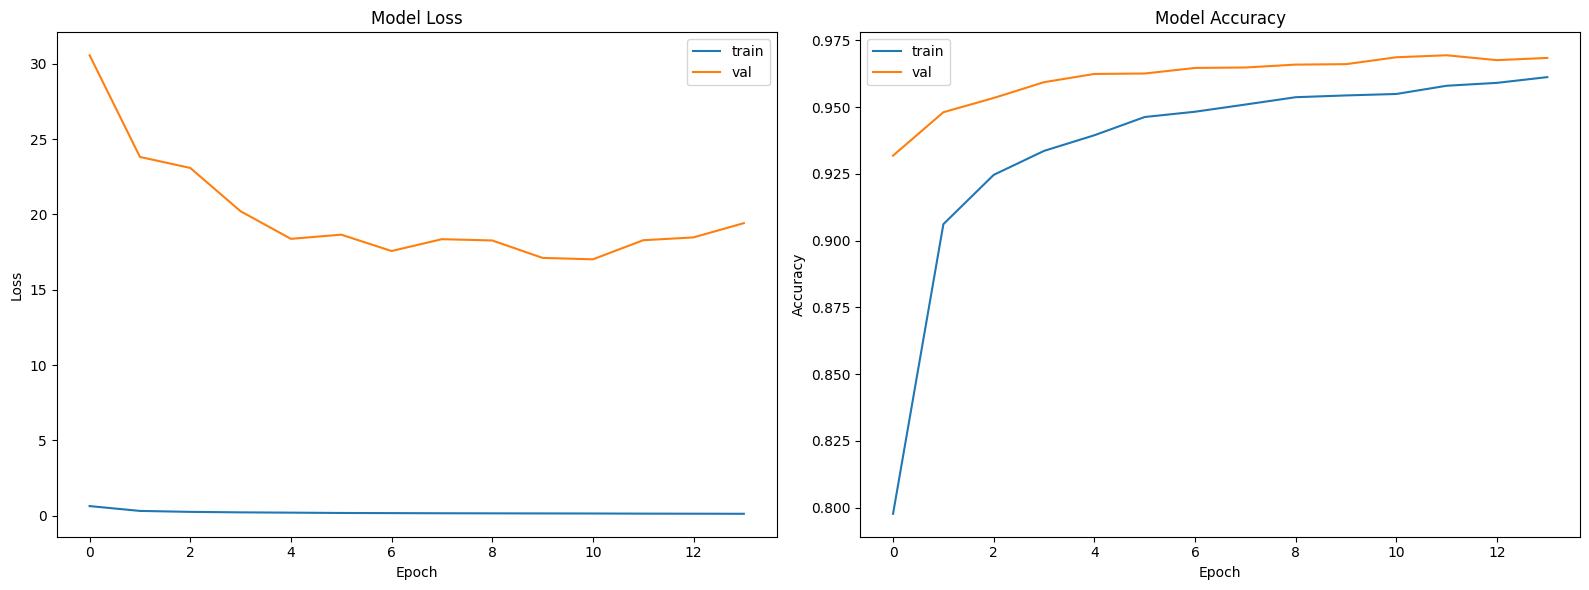

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy:  0.9719
F1 Score:  0.9716841705704631


In [92]:
sixthModel = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(28, 28)),  
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(10, activation='softmax')
])
compile_and_train_model_then_evaluate_its_performance(sixthModel)

There is a second popular way to regularise : L2 regularisation.
If you want to see how its done in keras see [here](https://keras.io/api/layers/regularizers/)

### Try 6 : Embedding preprocessing in the model

In [93]:
mnist = tf.keras.datasets.mnist # We load our data
(x_train, y_train),(x_test, y_test) = mnist.load_data() # We split it into test and train

In [94]:
eightModel = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(28, 28)),  
  tf.keras.layers.Flatten(),
  tf.keras.layers.Rescaling(scale=1./127.5, offset=-1), # Ensures the pixels are between -1 and 1
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

##### ☑ If time permits (but come back to this place if you have time @ the end): compile and train it. Plot the history.

Epoch 1/25
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 47s 7ms/step - accuracy: 0.8654 - loss: 0.4275 - val_accuracy: 0.9417 - val_loss: 0.1903
Epoch 2/25
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 38s 6ms/step - accuracy: 0.9289 - loss: 0.2319 - val_accuracy: 0.9532 - val_loss: 0.1545
Epoch 3/25
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - accuracy: 0.9434 - loss: 0.1889 - val_accuracy: 0.9645 - val_loss: 0.1143
Epoch 4/25
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step - accuracy: 0.9492 - loss: 0.1649 - val_accuracy: 0.9697 - val_loss: 0.0965
Epoch 5/25
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - accuracy: 0.9556 - loss: 0.1474 - val_accuracy: 0.9749 - val_loss: 0.0804
Epoch 6/25
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 50s 8ms/step - accuracy: 0.9586 - loss: 0.1361 - val_accuracy: 0.9766 - val_loss: 0.0746
Epoch 7/25
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 50s 8ms/step - accuracy: 0.9608 - loss: 0.1239 - val_accuracy: 0.9771 - val_loss: 0.0713
Epoch 8/25
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step - accuracy: 0.9615 - loss: 0

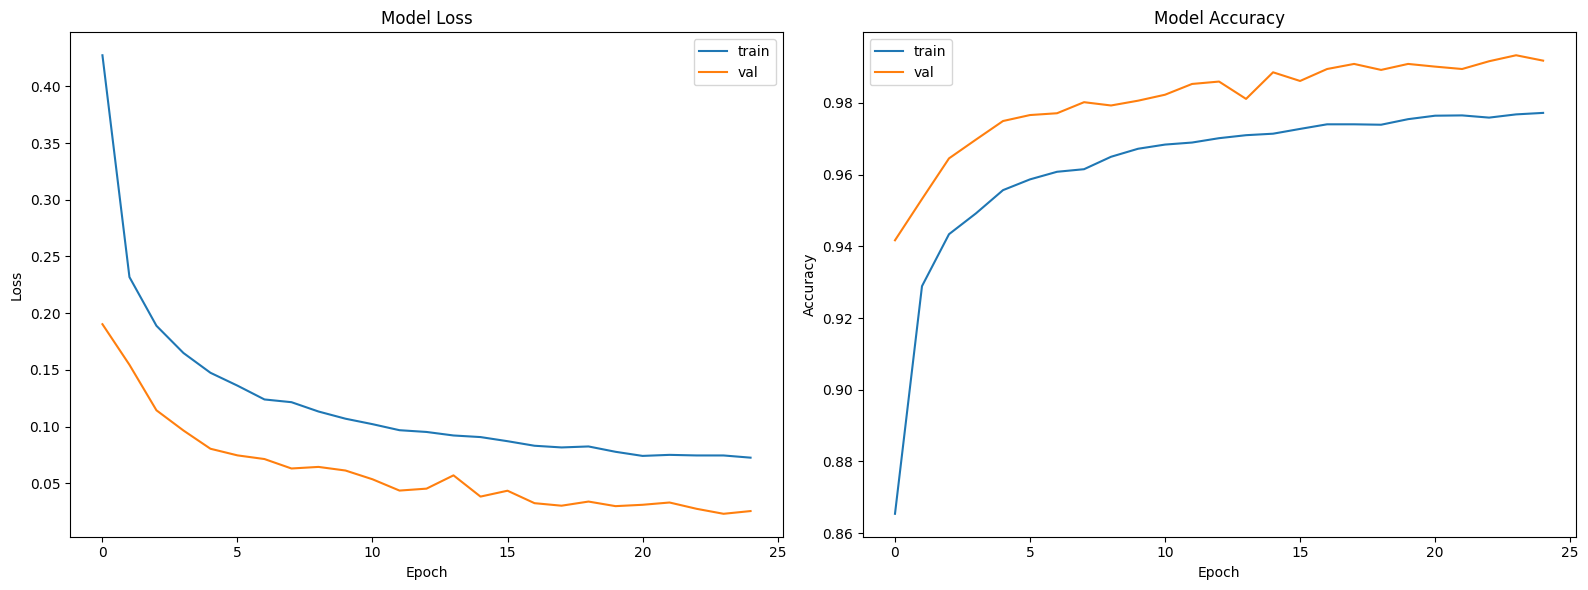

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Accuracy:  0.9776
F1 Score:  0.977431954422521


In [95]:
compile_and_train_model_then_evaluate_its_performance(eightModel)

## Functional API 

With the sequential API we can only define a fairly simple network architecture. 
The layers follow each other 'sequentially'

In case we would like to create more fancy architectures e.g 
- with multiple inputs or
- with bypasses etc..or..
then we need a different API : the functional one.
Lets create our second model but this time with the fuctional API...

In [96]:
inputs = tf.keras.Input(shape=(28,28))
x = tf.keras.layers.Flatten()(inputs)
x = tf.keras.layers.Dense(64, activation=tf.keras.activations.relu)(x) # you can pass in a function or a string
x = tf.keras.layers.Dense(32, activation='relu')(x) # you can pass in an object or a string
outputs = tf.keras.layers.Dense(10, activation="softmax")(x)

In [97]:
functionalModel = tf.keras.Model(inputs=inputs, outputs=outputs, name="mnist_model")

##### ☑ Visualise the architecture textually to investigate it. 

In [98]:
functionalModel.summary()

Model: "mnist_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,650 (205.66 KB)

 Trainable params: 52,650 (205.66 KB)

 Non-trainable params: 0 (0.00 B)

##### ☑ How does it differ from one with the sequential API?

There is an "input layer" added

Let's design a network with a 'bypass' to demonstrate the extra functionality of this interface.

In [99]:
input_  = tf.keras.layers.Input(shape=[28, 28])
flatten = tf.keras.layers.Flatten()(input_)
hidden1 = tf.keras.layers.Dense(2**14, activation="relu")(flatten)
hidden2 = tf.keras.layers.Dense(512, activation='relu')(hidden1)
hidden3 = tf.keras.layers.Dense(28*28, activation='relu')(hidden2)
reshap  = tf.keras.layers.Reshape((28, 28))(hidden3)
concat_ = tf.keras.layers.Concatenate()([input_, reshap])
flatten2= tf.keras.layers.Flatten()(concat_)
output  = tf.keras.layers.Dense(10, activation='softmax')(flatten2)
functionalModelwithBypass = tf.keras.Model(inputs=[input_], outputs=[output] )

In [100]:
functionalModelwithBypass.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 28, 28)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_13          │ (None, 784)       │          0 │ input_layer_13[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_39 (Dense)    │ (None, 16384)     │ 12,861,440 │ flatten_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_40 (Dense)    │ (None, 512)       │  8,389,120 │ dense_39[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_41 (Dense)    │ (None, 784)       │    402,192 │ dense_40[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 28, 28)    │          0 │ dense_41[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 28, 56)    │          0 │ input_layer_13[0… │
│ (Concatenate)       │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_14          │ (None, 1568)      │          0 │ concatenate[0][0] │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_42 (Dense)    │ (None, 10)        │     15,690 │ flatten_14[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 21,668,442 (82.66 MB)

 Trainable params: 21,668,442 (82.66 MB)

 Non-trainable params: 0 (0.00 B)

plot_model(functionalModelwithBypass, show_shapes=True, show_layer_names=True) would give use
<center><img src= "images/functionalModelwithBypass.webp" style="background-color:white; max-width:50%"></center>

## Model subclassing
Just for completeness we mention that if you even want to do more complex stuff like e.g. creating youw own layer types (researchers,advanced ai)
you may want to use yet another keras API-> subclassing. A simple example here below.

In [101]:
class MNISTmodel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        # The order does not matter, you can place them however you want here
        self.flatten = tf.keras.layers.Flatten()
        self.d3 = tf.keras.layers.Dense(10, activation="softmax")
        # here
        self.d1  = tf.keras.layers.Dense(64, activation='relu')
        # here
        self.d2  = tf.keras.layers.Dense(32, activation='relu')

    def call(self, x): # You must implement this method. This is the order in which the neural network does its predictions
        x = self.flatten(x) # It first flattens the input
        x = self.d1(x) # Afterwards it sends it to the first 64 regressions
        x = self.d2(x) # The second 32 regressions
        return self.d3(x) # returns the predictions
subclassModel = MNISTmodel()

##### ☑ If time permits (but come back to this place if you have time @ the end): compile and train it. Plot the history.

Epoch 1/25
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 39s 6ms/step - accuracy: 0.7433 - loss: 2.4805 - val_accuracy: 0.8614 - val_loss: 0.5000
Epoch 2/25
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - accuracy: 0.8928 - loss: 0.4076 - val_accuracy: 0.9268 - val_loss: 0.2650
Epoch 3/25
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - accuracy: 0.9302 - loss: 0.2596 - val_accuracy: 0.9383 - val_loss: 0.2336
Epoch 4/25
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.9460 - loss: 0.1967 - val_accuracy: 0.9613 - val_loss: 0.1322
Epoch 5/25
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.9561 - loss: 0.1572 - val_accuracy: 0.9620 - val_loss: 0.1260
Epoch 6/25
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9616 - loss: 0.1331 - val_accuracy: 0.9675 - val_loss: 0.1119
Epoch 7/25
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - accuracy: 0.9668 - loss: 0.1143 - val_accuracy: 0.9669 - val_loss: 0.1181
Epoch 8/25
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 54s 9ms/step - accuracy: 0.9703 - loss: 0

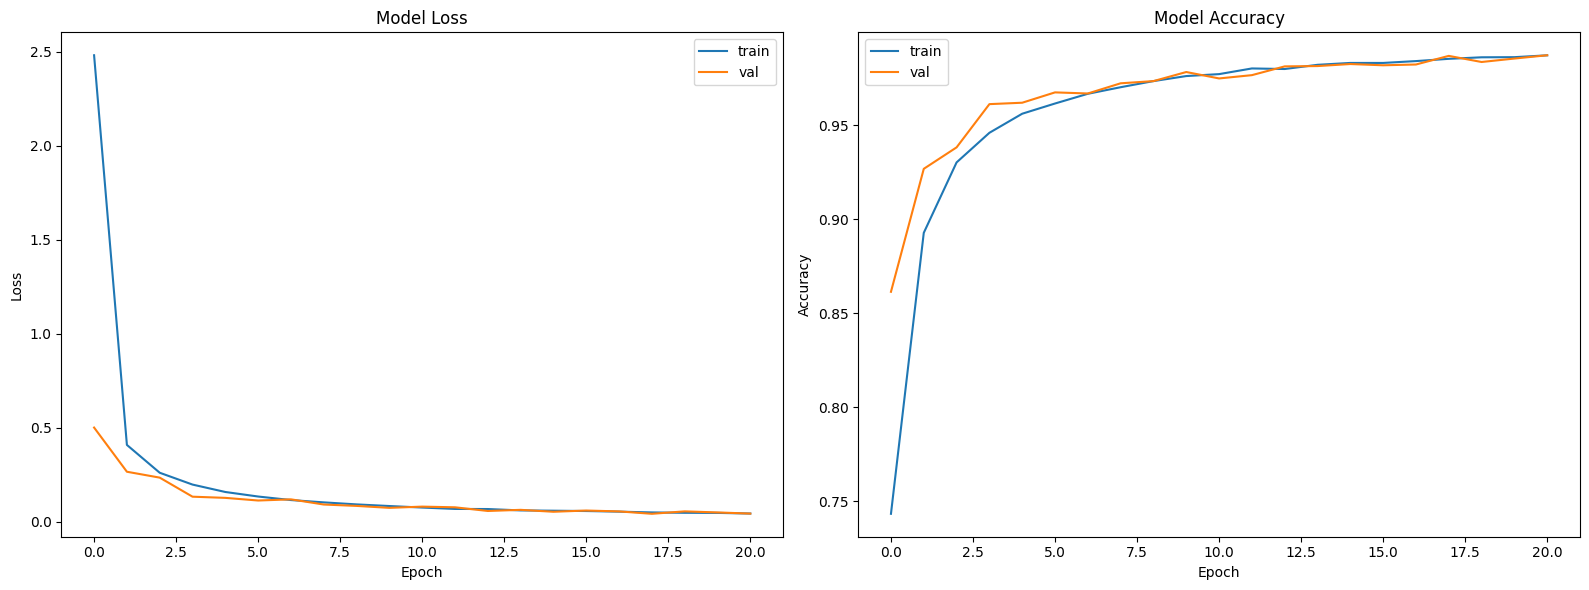

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Accuracy:  0.9631
F1 Score:  0.9628542180139809


In [102]:
compile_and_train_model_then_evaluate_its_performance(subclassModel)

Neural networks libraries frequently contain data preparation functionality. Since neural networks "learn" features from the data they can effectively do the entire data preparation and modelling steps of crisp-dm in one.

Previously we scaled the data to be between 0 and 1. We can do this within our layers with a Rescaling layer. Other operations such as one hot encoding can be done within the neural network as well.

## Hyper parameter tuning

There is not a single way to designing and training neural nets. Try and error...is often the way to find a good nb of layers, with a number of neurons that works well for your problem.
Other 'hyper prarameters' (that is what these are called) are
* Activation function
* The amount of drop out layers
* For each drop out layer, the drop out rate
* The optimizer you will use
* The learning rate for the optimizer
* Loss function
* Batch size

The number of potential hyper-parameter combinations to try out is **HUUUUGE**. You could manually change some combinations...and evaluate the performance of your resulting model. 

### Some tips

💡 **Frequently neural networks are too big to train using cross validation and/or grid search.** Even on GPU it would take too long to train large neural networks sequentially and training them in parallel requires expensive GPU's. 

💡 **We do recommend you to change parameters one by one.** Never change two parameters at the same time if you're manually tuning. For example, adding drop out AND increasing the size. Split it up into 2 separate "experiments" to see the effect of each separately.

💡 **Favour smaller models over larger ones**. Think about the final assignment, a large model makes slower predictions and takes longer to train. If two models have near equal performance you should go for the smallest version. TIP: when training neural networks you can start with a large network that overfits and gradually make it smaller and/or add drop-out until it no longer overfits and captures the patterns correctly.

Training neural networks is time-consuming, both in terms of CPU time as in terms of engineer time. Use them where necessary but try simple things first. 

### Optuna

If you do this hyper tuning exercise manually, you may soon loose the overview.
[Optuna](https://optuna.org/) is a package that helps you to get this search for the wholy grale a bit organised.  
Optuna is a sophisticated hyperparameter optimization framework that goes beyond simple trial-and-error or random combinations of parameters. It employs more advanced and intelligent strategies to efficiently find high-performing hyperparameter configurations. 

Below you find some code that searches the hyper parameter space for the network we were using above.

In a nutshell : Optuna can **suggest** (see the trial.suggest functions) an hyperparameter from a range or set that you define.
In a loop it will use these suggested hyper parameters to optimise an objective function defined by you.
When done..there are some nice visualisations of the results.

In [103]:
import optuna
import plotly
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances

In [104]:
verbosity=True
epochs=5           # keep this small (5) if you only want to test the code
nb_trials= 5        # keep  this small(5) if you only want to test the code

In [105]:
def make_model( layer_sizes):
    inputs = tf.keras.Input(shape=(28, 28))
    x = tf.keras.layers.Flatten()(inputs)
    x=  tf.keras.layers.Rescaling(scale=1./127.5, offset=-1)(x) # Ensures the pixels are between -1 and 1
    for size in layer_sizes: 
        x = tf.keras.layers.Dense(size, activation='relu')(x) 

    outputs = tf.keras.layers.Dense(units=10, activation="softmax")(x)

    return tf.keras.Model(inputs, outputs)

In [106]:
def calculate_performance(x_test,y_test,mod):
    y_test_pred=np.argmax(mod.predict(x_test),axis=1)
    #acc= accuracy_score(y_test,y_test_pred)
    #print("Accuracy: ", acc)
    f1 = f1_score(y_test, y_test_pred, average='macro')
    #print("F1 Score: ", f1)
    return f1

In [107]:
def objective(trial): # we use optuna to finetune the hyper parameters
    # the hyper parameters are 
    nb_layers = trial.suggest_categorical("nb_layers", [2,3])
    layer_sizes=[]
    for i in range(nb_layers) :
        layer_size =trial.suggest_categorical("lay"+str(i), [32,64,128])
        layer_sizes.append(layer_size)

    weigth_init_seed=trial.suggest_int("seed",1,46)

    print('trial '+str(trial.number)+' optuna suggested layer sizes:'+str(layer_sizes)+' and weigth init seed:'+str(weigth_init_seed))
    
    model = make_model(layer_sizes=layer_sizes)
    if verbosity:
        print(model.summary())
        #keras.utils.plot_model(model, show_shapes=True)

    # Set random seed for reproducibility
    np.random.seed(weigth_init_seed)
    
    model.compile(
            optimizer=tf.keras.optimizers.Adam(0.0001),
            loss=tf.keras.losses.sparse_categorical_crossentropy,
            metrics=['accuracy'],
            )
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3) # If the validation loss rises for 3 epochs training is stopped
    history = model.fit(x_train, y_train, epochs=epochs,callbacks=callback, batch_size=10, validation_data=(x_val, y_val))
    plotTrainingHistory(history)        

    return calculate_performance(x_test,y_test,model)

##### ☑ What are the hyper parameters that are tuned in this objective function?

Number of layers, size of the layers, init weight

[I 2025-10-12 21:25:14,923] A new study created in memory with name: no-name-54b476d8-871c-4672-9502-33e7c8786987


trial 0 optuna suggested layer sizes:[32, 128, 64] and weigth init seed:36


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,250 (149.41 KB)

 Trainable params: 38,250 (149.41 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 42s 6ms/step - accuracy: 0.8545 - loss: 0.4889 - val_accuracy: 0.9141 - val_loss: 0.2903
Epoch 2/5
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 35s 6ms/step - accuracy: 0.9233 - loss: 0.2527 - val_accuracy: 0.9344 - val_loss: 0.2216
Epoch 3/5
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - accuracy: 0.9391 - loss: 0.2026 - val_accuracy: 0.9458 - val_loss: 0.1816
Epoch 4/5
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - accuracy: 0.9481 - loss: 0.1714 - val_accuracy: 0.9532 - val_loss: 0.1518
Epoch 5/5
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.9554 - loss: 0.1488 - val_accuracy: 0.9598 - val_loss: 0.1286


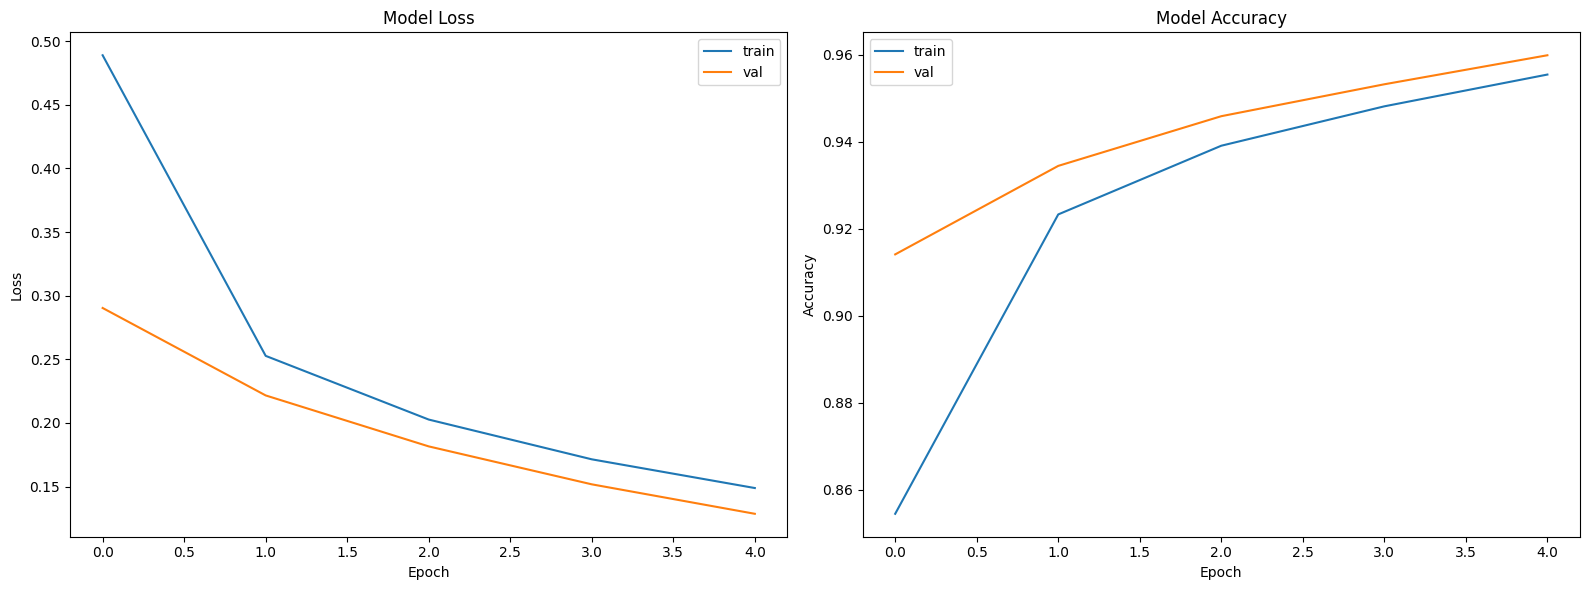

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


[I 2025-10-12 21:27:57,186] Trial 0 finished with value: 0.9537829140001126 and parameters: {'nb_layers': 3, 'lay0': 32, 'lay1': 128, 'lay2': 64, 'seed': 36}. Best is trial 0 with value: 0.9537829140001126.


trial 1 optuna suggested layer sizes:[128, 128, 64] and weigth init seed:26


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 125,898 (491.79 KB)

 Trainable params: 125,898 (491.79 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 52s 8ms/step - accuracy: 0.8868 - loss: 0.3807 - val_accuracy: 0.9327 - val_loss: 0.2238
Epoch 2/5
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - accuracy: 0.9464 - loss: 0.1792 - val_accuracy: 0.9544 - val_loss: 0.1541
Epoch 3/5
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9611 - loss: 0.1309 - val_accuracy: 0.9660 - val_loss: 0.1149
Epoch 4/5
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9691 - loss: 0.1036 - val_accuracy: 0.9728 - val_loss: 0.0895
Epoch 5/5
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9740 - loss: 0.0854 - val_accuracy: 0.9781 - val_loss: 0.0720


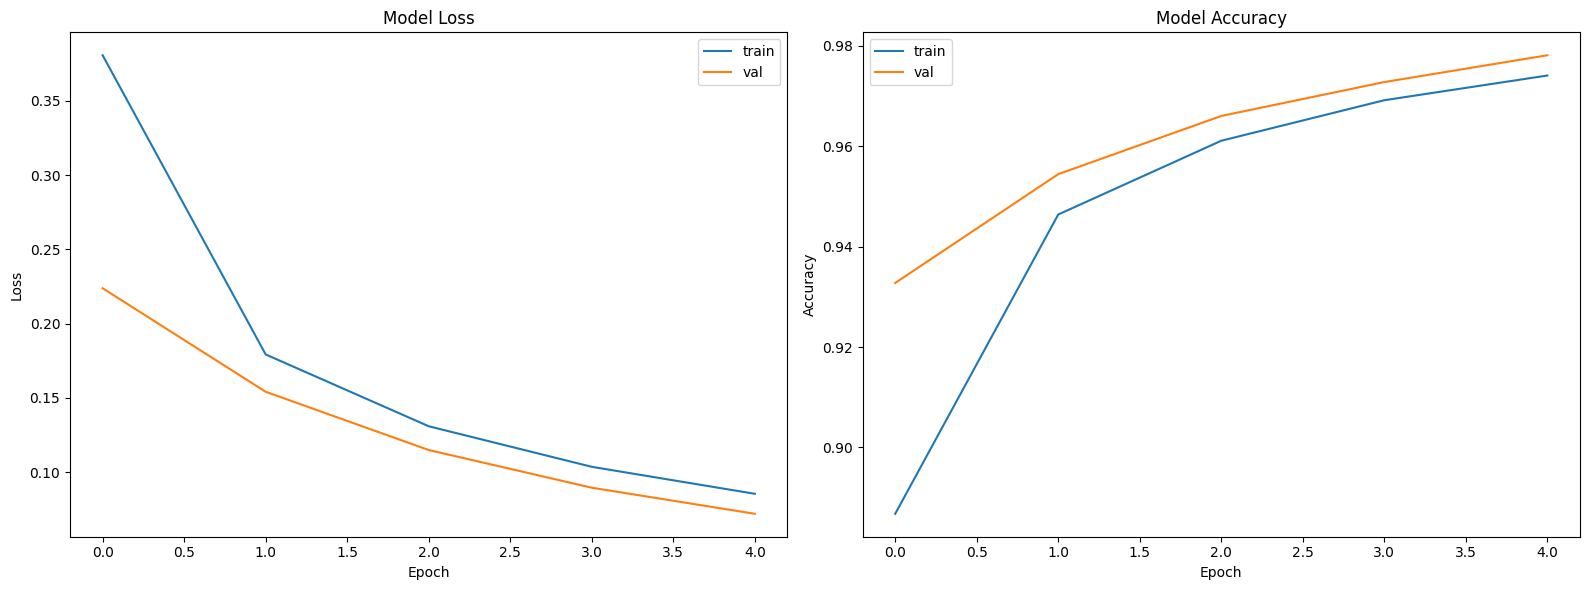

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step


[I 2025-10-12 21:29:54,357] Trial 1 finished with value: 0.9685638634630809 and parameters: {'nb_layers': 3, 'lay0': 128, 'lay1': 128, 'lay2': 64, 'seed': 26}. Best is trial 1 with value: 0.9685638634630809.


trial 2 optuna suggested layer sizes:[128, 128, 64] and weigth init seed:15


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 125,898 (491.79 KB)

 Trainable params: 125,898 (491.79 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8831 - loss: 0.3912 - val_accuracy: 0.9323 - val_loss: 0.2303
Epoch 2/5
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9420 - loss: 0.1920 - val_accuracy: 0.9542 - val_loss: 0.1528
Epoch 3/5
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9582 - loss: 0.1387 - val_accuracy: 0.9646 - val_loss: 0.1188
Epoch 4/5
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9673 - loss: 0.1087 - val_accuracy: 0.9717 - val_loss: 0.0985
Epoch 5/5
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9732 - loss: 0.0886 - val_accuracy: 0.9754 - val_loss: 0.0837


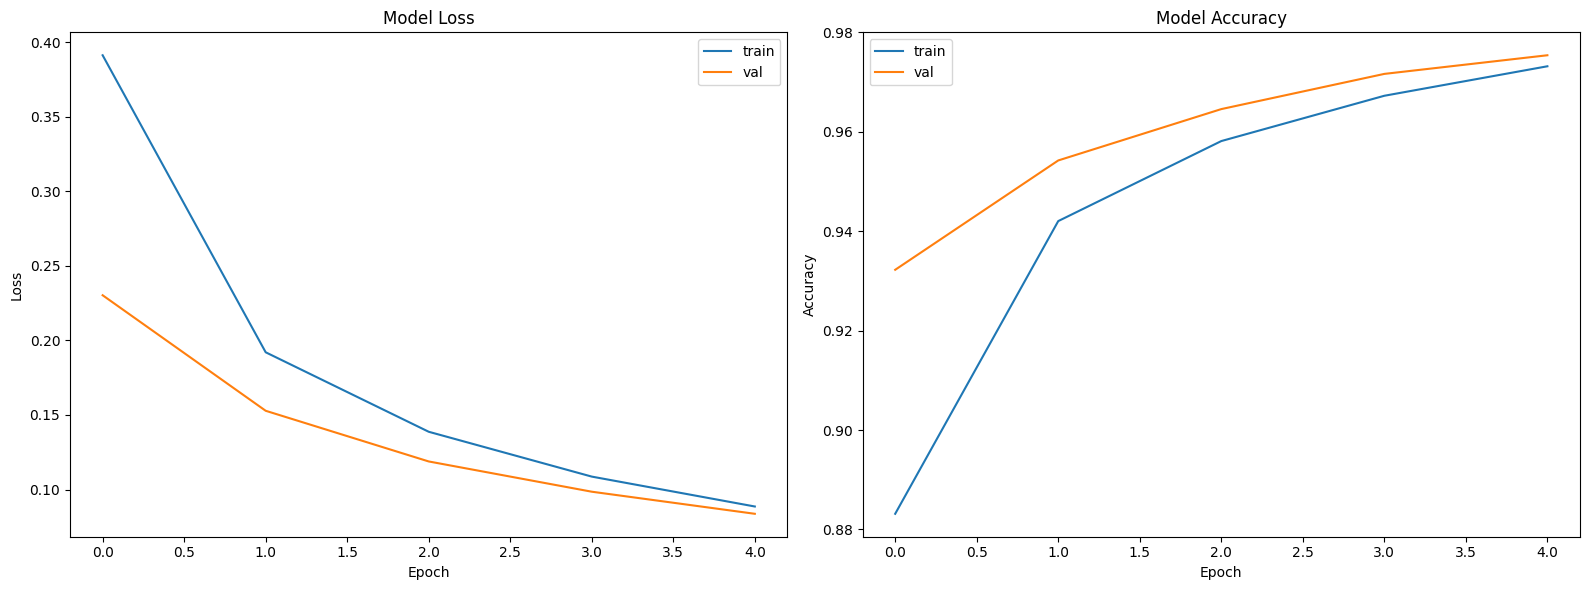

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step


[I 2025-10-12 21:30:50,034] Trial 2 finished with value: 0.9658693644367637 and parameters: {'nb_layers': 3, 'lay0': 128, 'lay1': 128, 'lay2': 64, 'seed': 15}. Best is trial 1 with value: 0.9685638634630809.


trial 3 optuna suggested layer sizes:[64, 128] and weigth init seed:12


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_4 (Rescaling)         │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,850 (233.79 KB)

 Trainable params: 59,850 (233.79 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.8730 - loss: 0.4421 - val_accuracy: 0.9266 - val_loss: 0.2539
Epoch 2/5
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.9337 - loss: 0.2255 - val_accuracy: 0.9452 - val_loss: 0.1827
Epoch 3/5
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.9499 - loss: 0.1702 - val_accuracy: 0.9582 - val_loss: 0.1419
Epoch 4/5
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.9593 - loss: 0.1380 - val_accuracy: 0.9653 - val_loss: 0.1176
Epoch 5/5
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.9653 - loss: 0.1171 - val_accuracy: 0.9709 - val_loss: 0.0994


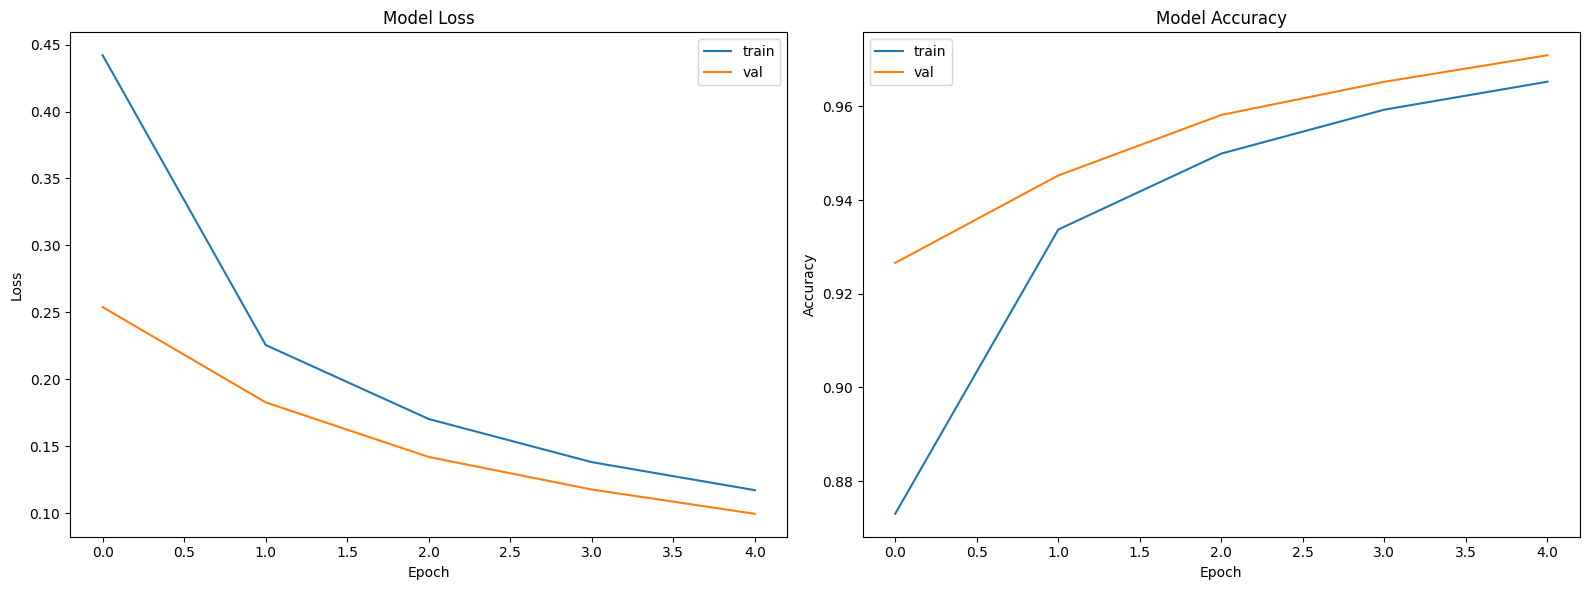

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step


[I 2025-10-12 21:31:29,981] Trial 3 finished with value: 0.9631058970471678 and parameters: {'nb_layers': 2, 'lay0': 64, 'lay1': 128, 'seed': 12}. Best is trial 1 with value: 0.9685638634630809.


trial 4 optuna suggested layer sizes:[128, 32, 64] and weigth init seed:40


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_5 (Rescaling)         │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,370 (419.41 KB)

 Trainable params: 107,370 (419.41 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.8741 - loss: 0.4348 - val_accuracy: 0.9269 - val_loss: 0.2454
Epoch 2/5
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9361 - loss: 0.2165 - val_accuracy: 0.9497 - val_loss: 0.1732
Epoch 3/5
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9517 - loss: 0.1637 - val_accuracy: 0.9606 - val_loss: 0.1327
Epoch 4/5
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9603 - loss: 0.1333 - val_accuracy: 0.9647 - val_loss: 0.1143
Epoch 5/5
6000/6000 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9660 - loss: 0.1131 - val_accuracy: 0.9665 - val_loss: 0.1043


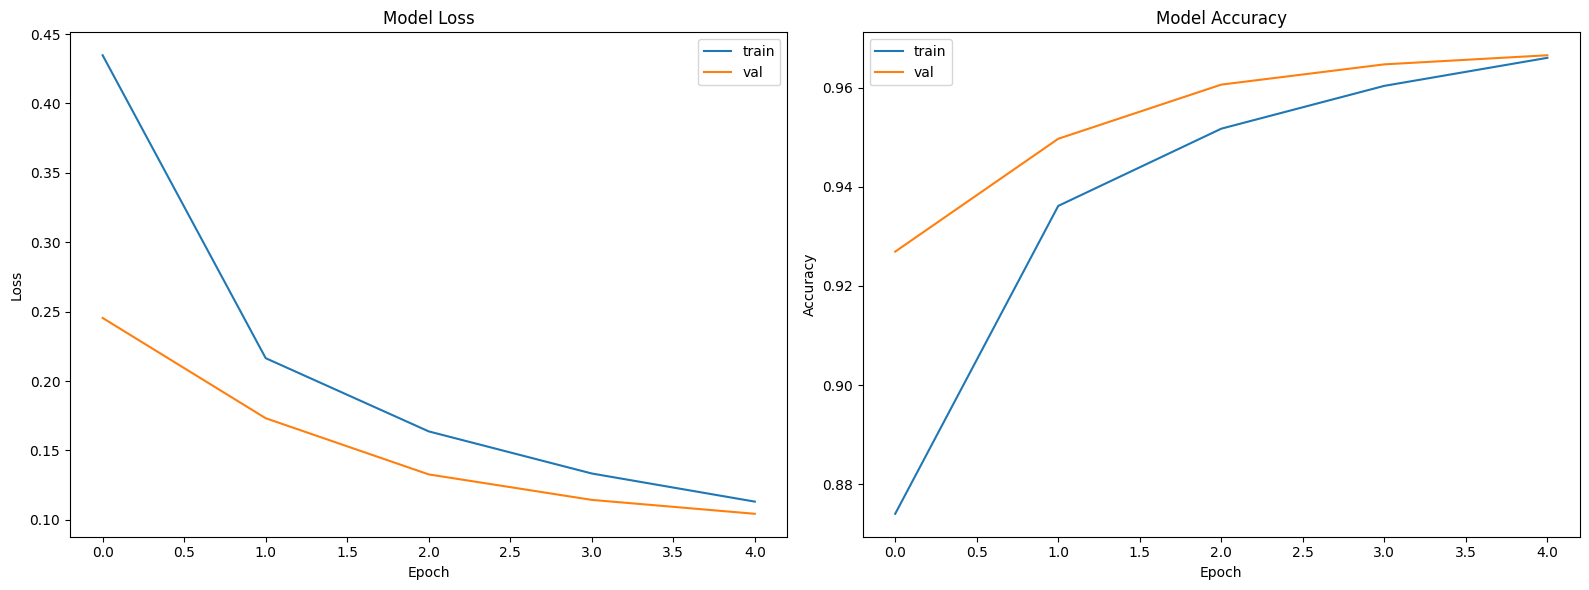

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step


[I 2025-10-12 21:32:31,136] Trial 4 finished with value: 0.9608249772344495 and parameters: {'nb_layers': 3, 'lay0': 128, 'lay1': 32, 'lay2': 64, 'seed': 40}. Best is trial 1 with value: 0.9685638634630809.


{'nb_layers': 3, 'lay0': 128, 'lay1': 128, 'lay2': 64, 'seed': 26}

In [108]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=nb_trials)
study.best_params 

In [109]:
plotly.io.renderers.default = "browser"

In [110]:
plot_parallel_coordinate(study)

In case there is no time to run it :The line above should give you :
<center><img src= "images/parralel_coordinate_plot.png" , max-width:50%"></center>

In [111]:
plot_param_importances(study)

In case there is no time to run it :The line above should give you :
<center><img src= "images/parameter_importance.png" ></center>

## Final take away
These days there are a lot of large 'pre-trained' models available. 
Instead off of designing your own architecture and train it with a (usually) limited set of data that you have access to, it is often much more efficient to fine tune these pretrained networks using the technique of transfer learning.
This will be explained in the next lesson (computer vision). Stay tuned!